# Analysis of $C_{60}$ in a static electric field

We consider a $C_{60}$ molecule in a static electric field. We present results for field directed in the z directions. Other directions should provide the same results due to the spherical symmetry of the system.  
The main aim of this analysis is to determine the minimum dimension allowed of the simulation box as a function of the field intensity. As a criterium of consistency we require that the energy of the occupied KS orbitals should remain constant as the dimension of the box is increased.  

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'static-field/'

Autosave disabled


First of all we define the python dictionary that contains the basic keys common to all the file in the run and we write these common variables in the default file

In [2]:
inp0 = {'dft' : 
        {'hgrids': 0.40,
         'gnrm_cv' : 1e-8,
         'itermax' : 100},
        'posinp': 'C60_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

We perform the analysis for different values of the field norm and different boz sizes

## Generation and execution of the input files

In [7]:
enorm = [[0.0,str('0_')],[1e-4,str('1em4_')], [1e-3,str('1em3_')],[1e-2,str('1em2_')], [5e-2,str('5em2_')]]#, [1e-1,str('1em1_')]]
rVal = [float(i) for i in range(5,9)]
print enorm
print rVal

[[0.0, '0_'], [0.0001, '1em4_'], [0.001, '1em3_'], [0.01, '1em2_'], [0.05, '5em2_']]
[5.0, 6.0, 7.0, 8.0]


We generate the input files and the run files (one for each value of the field norm)

In [8]:
for e in enorm:
    ez=[0.0,0.0,e[0]]
    inpEz={'dft':{'elecfield': ez}}
    lrun=[]
    for r in rVal:
        inpEz['dft']['rmult'] = [r, 9.0]
        inpnameEz = 'Ez_'+e[1]+str('rmult_')+str(r)
        Yaml.dump(inpEz,outputpath + inpnameEz + '.yaml')
        lrun.append(inpnameEz)
    Yaml.dump(lrun,outputpath+'runs_'+e[1])

We execute the run files

In [5]:
code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
for e in enorm:
    code.run(run_name='runs_'+e[1],skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C60/static-field
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_0_ -d ./log/ -s Yes
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_1em4_ -d ./log/ -s Yes
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_1em3_ -d ./log/ -s Yes
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_1em2_ -d ./log/ -s Yes
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_5em2_ -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C60


## Data Analysis

We discuss the results of these computations. In particular we analyze the scaling of the energy of the occupied orbitals for each value of the field and we check the if the choosen value of the field belong the regime of linear response.

We read all the log files and organize them in a lists sorted according to the field norm

In [9]:
EzLog = []
%cd $outputpath
for e in enorm:
    spath = 'log/'+str('log-Ez_')+e[1]+str('*') 
    logsEz = !ls $spath
    #print logsEz
    EzLog.append([lf.Logfile(l) for l in logsEz])
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C60/static-field
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C60


In [44]:
# The first index select the field, the second the box. For intance:
print EzLog[3][0].log['dft']['elecfield']
print EzLog[0][2].log['dft']['rmult']
print EzLog[3][0].evals[0][0] #give the energy of the orbitals

[0.0, 0.0, 0.01]
[7.0, 9.0]
[-0.90406523 -0.88371887 -0.88371349 -0.88148953 -0.84786366 -0.84748279
 -0.84747466 -0.84689453 -0.84668375 -0.8103353  -0.80978222 -0.80957253
 -0.77939693 -0.77938286 -0.77936497 -0.779265   -0.73288118 -0.73277333
 -0.73274789 -0.7325422  -0.73244387 -0.71545067 -0.71537714 -0.71536081
 -0.71495678 -0.65998292 -0.65992781 -0.65955    -0.65952809 -0.65945691
 -0.65517231 -0.6551692  -0.65502351 -0.61861727 -0.61842405 -0.61792063
 -0.57878126 -0.57862126 -0.57851652 -0.5781538  -0.57783854 -0.57273018
 -0.57254708 -0.57254424 -0.56431511 -0.51967888 -0.51965213 -0.51954833
 -0.51948294 -0.49056056 -0.49049244 -0.49023088 -0.49014574 -0.49014051
 -0.4824879  -0.48248446 -0.48235182 -0.46186206 -0.4601571  -0.46013802
 -0.46009524 -0.43777178 -0.43776275 -0.43558334 -0.43548349 -0.43543542
 -0.43539375 -0.43452166 -0.41678819 -0.41646394 -0.41645458 -0.4159481
 -0.41591079 -0.40273179 -0.40266196 -0.40230855 -0.40215724 -0.3964367
 -0.3962187  -0.39571262 

We define some useful parameters

In [18]:
numField = len(EzLog)
numBox = len(EzLog[0])
numOrb = len(EzLog[0][0].evals[0][0])
print 'numField',numField
print 'numBox', numBox
print 'numOrb', numOrb

numField 5
numBox 4
numOrb 120


### Energy scaling of the occupied orbitals vs. size of the simulation box

We chose a value of the field norm

In [23]:
eind = 3
print 'Field norm = ' + enorm[eind][1]

Field norm = 1em2_


Plot the energy of each orbitals in function of the size of the box (z dimension) (for both directions of the field)

Ez [0.0, 0.0, 0.01]


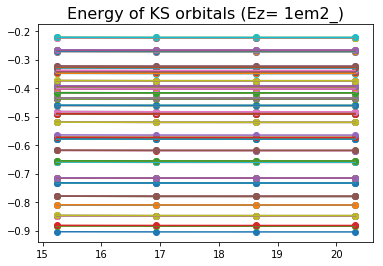

In [24]:
print  'Ez',EzLog[eind][0].log['dft']['elecfield']
enOrbEz=[]
for orb in range(numOrb):
    eorb=[]
    for box in range(numBox):
        eorb.append(EzLog[eind][box].evals[0][0][orb])
    enOrbEz.append(eorb)
    
dimBox=[]
for box in range(numBox):
    dimBox.append(EzLog[eind][box].log['Sizes of the simulation domain']['Angstroem'][2])

for orb in range(numOrb):
    plt.plot(dimBox,enOrbEz[orb])
    plt. scatter(dimBox,enOrbEz[orb])
    title = 'Energy of KS orbitals (Ez= '+ enorm[eind][1]+str(')')
plt.title(title,fontsize=16)
plt.show()

These plots evidence that the orbitals are not stable for norm of the field greater than $1e^{-2}$. So we conlude that a field norm equal to $1e^{-2}$ is the highest value compatible with a static stable deformation

Now we perform some plots that aim to extablish a criterium for choosing the optimum value of the simulation box.

First of all we plot the difference between the energy of each orbital and its value for the greatest simulation box

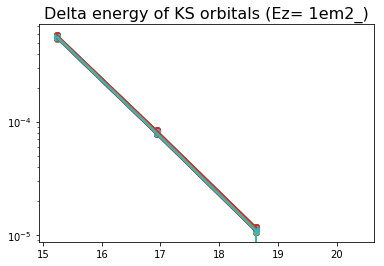

In [25]:
deltaEz=[]
for orb in range(numOrb):
    delta = enOrbEz[orb]-enOrbEz[orb][-1]
    deltaEz.append(delta)

for orb in range(numOrb):
    plt.plot(dimBox,deltaEz[orb])
    plt.scatter(dimBox,deltaEz[orb])
    title = 'Delta energy of KS orbitals (Ez= '+ enorm[eind][1]+str(')')
plt.title(title,fontsize=16)
plt.yscale('log')
plt.show()

We also plot the (module of the) difference between the energy of each orbital and its value in the box immeadetly lower.

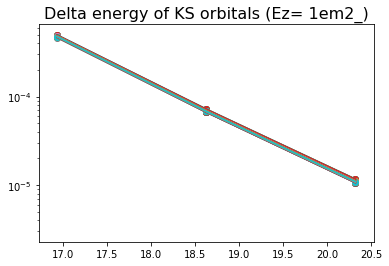

In [27]:
deltaEz=[]
for orb in range(numOrb):
    dz = []
    for i in range(numBox-1):
        dz.append(np.abs(enOrbEz[orb][i+1]-enOrbEz[orb][i]))
    deltaEz.append(dz)

dimBoxCut = [dimBox[i] for i in range(1,numBox)]

for orb in range(numOrb):
    plt.plot(dimBoxCut,deltaEz[orb])
    plt.scatter(dimBoxCut,deltaEz[orb])
    title = 'Delta energy of KS orbitals (Ez= '+ enorm[eind][1]+str(')')
plt.title(title,fontsize=16)
plt.yscale('log')
plt.show()

These plots evidence that the scaling of the energy with the size of the box reduce exponentially and for rmult = 7.0
is lower than $1e^{-4}$. 

### Computation of the static polarizability

We build the following lists, with the values of the x and z components of the induced dipole moments of the fields. We use these values to check the linearity of the dipole moments with respect to the field

In [71]:
box = 2
eMax = 3
print 'rmult = ', EzLog[0][box].log['dft']['rmult'][0]
print 'Max Field norm = ' + enorm[eMax][1]

rmult =  7.0
Max Field norm = 1em2_


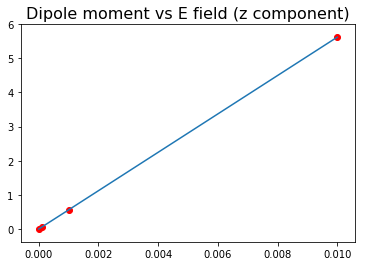

alphaZ =  561.594233465
intercept =  -0.000768661114624


In [72]:
dipoleZ=[]
eFieldZ=[]
for i in range(eMax+1):
    dipoleZ.append(EzLog[i][box].log['Electric Dipole Moment (AU)']['P vector'][2])
    eFieldZ.append(enorm[i][0])
    
# compute the induced dipole by subtracting the value of the dipole at zero field
indDipoleZ=[dipoleZ[i]-dipoleZ[0] for i in range(len(dipoleZ))]

plt.plot(eFieldZ,indDipoleZ)
plt.scatter(eFieldZ,indDipoleZ, color='r')
plt.title('Dipole moment vs E field (z component)',fontsize=16)
plt.show()

from scipy import stats
alphaZ, intercept, r_value, p_value, std_err = stats.linregress(eFieldZ,indDipoleZ)
print 'alphaZ = ', alphaZ
print 'intercept = ', intercept

We compute the variation of the energy of the orbitals induced by the electric field:

In [52]:
deltaEngOrb = abs(EzLog[3][2].evals[0][0]-EzLog[0][2].evals[0][0])
print deltaEngOrb
print 'min = ', min(deltaEngOrb), 'max = ', max(deltaEngOrb)

[  3.46856952e-03   1.78919667e-03   1.78388541e-03   4.47636798e-04
   1.58429988e-03   1.20121810e-03   1.19657505e-03   6.13484870e-04
   4.02628917e-04   9.34833074e-04   3.81156087e-04   1.72560349e-04
   1.29656356e-03   1.34119908e-03   1.32520834e-03   1.22245907e-03
   1.04575933e-03   9.38526010e-04   9.14393087e-04   7.33243168e-04
   6.35293821e-04   1.15337695e-03   1.17767589e-03   1.16251216e-03
   7.61369891e-04   9.72378542e-04   9.23277631e-04   5.51084355e-04
   5.30638334e-04   4.64246517e-04   1.04360526e-03   1.04442727e-03
   9.03086575e-04   1.75040049e-03   1.56132906e-03   1.05980746e-03
   8.56314767e-04   7.04573797e-04   7.37922383e-04   3.78211167e-04
   6.51928577e-05   1.05032885e-03   8.71453642e-04   8.70992693e-04
   1.10603791e-03   1.48324534e-03   1.45771045e-03   1.35626105e-03
   1.34844605e-03   8.69214555e-04   8.06044740e-04   6.01311407e-04
   5.17631975e-04   5.16790686e-04   1.14561489e-03   1.14211352e-03
   1.01114726e-03   2.80427047e-03

### Write the occupied orbitals on disk

As a final task of this nb we compute the KS orbitals of the ground state for the field norm equal to $1e-2$, which is the highest computed value of the field for which the linear response regime has been confirmed.

In [41]:
eind = 3 # corresponds to enorm = 1e-2
rMult = [7.0] # value of rmult
ez=[0.0,0.0,enorm[eind][0]]
inpEz={'dft':{'elecfield': ez},
       'output': {'orbitals' : 'binary'}}
lrun=[]
for r in rMult:
    inpEz['dft']['rmult'] = [r, 9.0]
    inpEz['radical'] = 'Ez_'+enorm[eind][1]+'rmult_'+str(r)
    inpnameEz = 'Ez_wf_'+enorm[eind][1]+str('rmult_')+str(r)
    Yaml.dump(inpEz,outputpath + inpnameEz + '.yaml')
    lrun.append(inpnameEz)
Yaml.dump(lrun,outputpath+'runs_wf')

We execute the input files

In [42]:
%cd $outputpath
code.run(run_name='runs_wf',skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C60/static-field
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_wf -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C60
